In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [2]:
housesale_df = pd.read_csv('dataset/kc_house_data_preprocessed.csv', dtype = float)

housesale_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,age,renovated
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,47.5112,-122.257,1340.0,5650.0,66.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,47.7210,-122.319,1690.0,7639.0,70.0,1.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,47.7379,-122.233,2720.0,8062.0,88.0,0.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,47.5208,-122.393,1360.0,5000.0,56.0,0.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,47.6168,-122.045,1800.0,7503.0,34.0,0.0


In [3]:
x = housesale_df.drop('price', axis = 1)
y = housesale_df['price']

x.shape

(21613, 17)

In [4]:
from sklearn.feature_selection import f_regression, SelectKBest

select_features = SelectKBest(f_regression, k = 3)

In [5]:
x_new = select_features.fit_transform(x, y)

x_new.shape

(21613, 3)

In [6]:
x_new = pd.DataFrame(x_new)
x_new.head()

,0,1,2
0,1180.0,7.0,1180.0
1,2570.0,7.0,2170.0
2,770.0,6.0,770.0
3,1960.0,7.0,1050.0
4,1680.0,8.0,1680.0


In [7]:
selected_features = []

for i in range(len(x_new.columns)):
    for j in range(len(x.columns)):
        if(x_new.iloc[:, i].equals(x.iloc[:, j])):
            selected_features.append(x.columns[j])
            
selected_features

['sqft_living', 'grade', 'sqft_above']

In [8]:
rejected_features = set(list(x)) - set(selected_features)

rejected_features

{'age',
 'bathrooms',
 'bedrooms',
 'condition',
 'floors',
 'lat',
 'long',
 'renovated',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'waterfront'}

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2)

x_train.shape, y_train.shape

((17290, 3), (17290,))

In [10]:
model = sm.OLS(y_train, x_train)

In [11]:
result = model.fit()

In [12]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                          3.051e+04
Date:                Sun, 31 Jan 2021   Prob (F-statistic):                        0.00
Time:                        01:49:07   Log-Likelihood:                     -2.4010e+05
No. Observations:               17290   AIC:                                  4.802e+05
Df Residuals:                   17287   BIC:                                  4.802e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
FEATURES = list(housesale_df.columns[1:])
FEATURES

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'age',
 'renovated']

In [14]:
def build_model(regression_fn, target, features, dataset, preprocess_fn, *hyperparameters):
    
    x = dataset[features]
    y = dataset[target]
    
    x = preprocess_fn(x, y, *hyperparameters)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    
    model = regression_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return {'x_train' : x_train,
            'x_test': x_test,
            'y_train': y_train,
            'y_test' : y_test,
            'y_pred' : y_pred,
            'model' : model
         }

In [15]:
def compare_results(result_dict):
    
    for key in result_dict:
        print('Test: ', key)
        print('R-squared', result_dict[key]['rsquared'])
        print('Adjusted R-Square', result_dict[key]['adj_rsquared'])
        print()
        
    n_components = list(range(1, 18))
    reg_score = [result_dict[key]['adj_rsquared'] for key in result_dict]
    
    plt.figure(figsize = (10, 6))
    plt.plot(n_components, reg_score)
    
    pylab.ylim([0, 1])
    
    plt.xlabel('n_components')
    plt.ylabel('adj_rsquared')

In [16]:
def get_model_scores(model_params):
    
    result_dict = {}
    
    for key in model_params:
        result_dict[key] = {
                            'rsquared' : model_params[key]['model'].rsquared,
                            'adj_rsquared' : model_params[key]['model'].rsquared_adj
                            }
        
    compare_results(result_dict)

In [17]:
def ols_reg(x_train, y_train):
    
    ols = sm.OLS(y_train, x_train)
    model = ols.fit()
    
    return model

In [18]:
def apply_f_regression(x, y, k, add_constant = False):
    
    select_features = SelectKBest(f_regression, k = k)
    x_new = select_features.fit_transform(x, y)
    
    if add_constant is True:
        x_new = sm.add_constant(x_new)
        
    return pd.DataFrame(x_new)

In [19]:
model_params = {}

for i in range(1, 18):
    model_params['f_regression-k:' + str(i)] = build_model(ols_reg, 'price', FEATURES, housesale_df,
                                                          apply_f_regression, i, True)

Test:  f_regression-k:1
R-squared 0.49370056542388874
Adjusted R-Square 0.4936712792465069

Test:  f_regression-k:2
R-squared 0.5372956050429035
Adjusted R-Square 0.5372420729789298

Test:  f_regression-k:3
R-squared 0.5399532580652521
Adjusted R-Square 0.5398734165619659

Test:  f_regression-k:4
R-squared 0.5423259067233739
Adjusted R-Square 0.5422199942921846

Test:  f_regression-k:5
R-squared 0.545780191227853
Adjusted R-Square 0.5456487923014552

Test:  f_regression-k:6
R-squared 0.5769943977624539
Adjusted R-Square 0.576847546312276

Test:  f_regression-k:7
R-squared 0.5745112514698207
Adjusted R-Square 0.574363537965731

Test:  f_regression-k:8
R-squared 0.5758475533546186
Adjusted R-Square 0.5756757522247427

Test:  f_regression-k:9
R-squared 0.6415197729884385
Adjusted R-Square 0.6413538195241661

Test:  f_regression-k:10
R-squared 0.6614723581875954
Adjusted R-Square 0.6612960417074848

Test:  f_regression-k:11
R-squared 0.656462794739937
Adjusted R-Square 0.6562639769812356



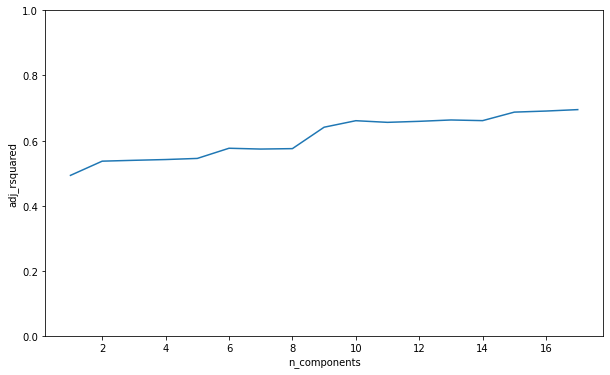

In [20]:
get_model_scores(model_params)

In [21]:
def linear_reg(x_train, y_train):
    
    model = LinearRegression().fit(x_train, y_train)
    
    return model

In [22]:
sklearn_model = {}
sklearn_model['f_regression'] = build_model(linear_reg, 'price', FEATURES, housesale_df,
                                            apply_f_regression, 9)

In [23]:
model = sklearn_model['f_regression']['model']
x_train = sklearn_model['f_regression']['x_train']
x_test = sklearn_model['f_regression']['x_test']
y_train = sklearn_model['f_regression']['y_train']
y_test = sklearn_model['f_regression']['y_test']
y_pred = sklearn_model['f_regression']['y_pred']

In [24]:
print('Trainin Score: ', model.score(x_train, y_train))
print('Test Score: ', r2_score(y_test, y_pred))

Trainin Score:  0.6374221173817467
Test Score:  0.6504985903661497


In [25]:
from sklearn.feature_selection import mutual_info_regression

def apply_mutual_info_regression(x, y, k, add_constant = False):
    
    select_features = SelectKBest(mutual_info_regression, k = k)
    x_new = select_features.fit_transform(x, y)
    
    if add_constant is True:
        x_new = sm.add_constant(x_new)
        
    return pd.DataFrame(x_new)

In [ ]:
model_params = {}

for i in range(1, 18):
    model_params['mutual_info_regressio - k: ' + str(i)] = build_model(ols_reg, 'price', FEATURES, housesale_df,
                                                                       apply_mutual_info_regression, i, True)

In [29]:
sklearn_model = {}

sklearn_model['mutual_info_regression'] = build_model(linear_reg, 'price',FEATURES, housesale_df,
                                                      apply_mutual_info_regression, 4 )

In [27]:
 model = sklearn_model['mutual_info_regression']['model']
x_train = sklearn_model['mutual_info_regression']['x_train']
x_test = sklearn_model['mutual_info_regression']['x_test']
y_train = sklearn_model['mutual_info_regression']['y_train']
y_test = sklearn_model['mutual_info_regression']['y_test']
y_pred = sklearn_model['mutual_info_regression']['y_pred']

In [28]:
print('Trainin Score: ', model.score(x_train, y_train))
print('Test Score: ', r2_score(y_test, y_pred))

Trainin Score:  0.6013199056465988
Test Score:  0.5793417304393491
